# Building Demand Method 1

Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

## RWI layer
rwi_path = in_path + "/Residential/Data/WealthIndex"
rwi_name = 'zmb_relative_wealth_index.csv'

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [7]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [8]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [9]:
grid = hexagons

## Extract raster values to hexagons

Extract count of buildings per hex

In [10]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_count.tif"
grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)      #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-08-22 16:47:52.639727


Extract population density from WorldPop

In [11]:
pathWorldPopPopCount = "Residential/Data/WorldPop/Copperbelt_population_v1_0_gridded.tif"
grid = processing_raster("popDens", "count", grid, filepath=pathWorldPopPopCount)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2023-08-22 16:48:20.031729


Extract urban areas from WorldPop

In [12]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2023-08-22 16:48:45.113938


Extract urbanisation level GHSL

In [13]:
# GHS Settlement Model grid (R2023) https://ghsl.jrc.ec.europa.eu/download.php?ds=smod
pathGHSMod ="Residential/Data/GHSL/Copperbelt_GHS_SMOD_E2020_GLOBE_R2023A_R11C21.tif"
grid = processing_raster("SMOD", "median", grid, filepath=pathGHSMod)  

2023-08-22 16:49:05.992363


Extract lighing data

In [14]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
pathHREA = "Residential/Data/Copperbelt_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
columnProbElec= "HREA"

2023-08-22 16:49:42.134654


Extract RWI

In [15]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)

# ## Run the extraction
# #grid.drop(['rwi'], axis=1, inplace=True) ##uncomment if you want to rerun
# columnNameRWI = "rwi"
# grid = spatialjoinvectors("RWI", columnNameRWI, admin_gdf, crs_WGS84, grid, 'mean')
# averageRwi = grid[columnNameRWI].mean()
# print(averageRwi)
# grid[columnNameRWI] = grid[columnNameRWI].fillna(averageRwi)

2023-08-22 16:50:07.030683


##### Once done with rasters run this cell

In [16]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-08-22 16:50:09.508944


In [17]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'SMODmedian': 'SMOD'}, axis=1, inplace=True)
grid.rename({'popDenscount': 'popDens'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)

Add values in RWi column when there is none

In [18]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)

In [19]:
grid.head(3)

,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingscount,popDens,locationWP,SMOD,HREA,rwi,geometry
0,873469a43ffffff,28.5112,-13.0582,0.0000,COPPERBELT,1,26,26,0.0000,NaN,0.6992,-0.3897,"POLYGON ((28.52398 -13.06274, 28.51388 -13.073..."
1,875536acdffffff,27.3135,-13.4529,0.0000,COPPERBELT,2,2,2,0.0000,NaN,0.0028,-0.3000,"POLYGON ((27.32628 -13.45739, 27.31616 -13.467..."
2,87553411bffffff,27.9715,-12.7327,0.0000,COPPERBELT,3,92,92,0.0000,NaN,0.5291,-0.3097,"POLYGON ((27.98428 -12.73706, 27.97422 -12.747..."


### Residential demand

In [20]:
# Retrieve values from the MTF survey
%run Residential/energy_demand_res.ipynb
energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
energyConsHH

Electricity consumption : 4,022,500,000 MWh
Electricity consumption : 4,022 TWh


CENTRAL         1,558
COPPERBELT      3,093
EASTERN         1,260
LUAPULA         2,630
LUSAKA          2,982
NORTH WESTERN   2,172
SOUTHERN        1,742
WESTERN           288
TOTAL           2,710
Name: annual, dtype: float64

In [21]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[columnProbElec] > 0))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
elec       4410
nonelec     756
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [26]:
# for each hexagon, determine if it's rural or urban --> choose best source
grid["locAssessed"] = grid.apply(lambda row: ("rural" if ((row['buildingscount'] < 80)) # number chosen to get 1 for nb of HH per rural building
                                             else "urban"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
                                             else "rural"), axis=1)
grid["location"] = grid["locAssessed"] 

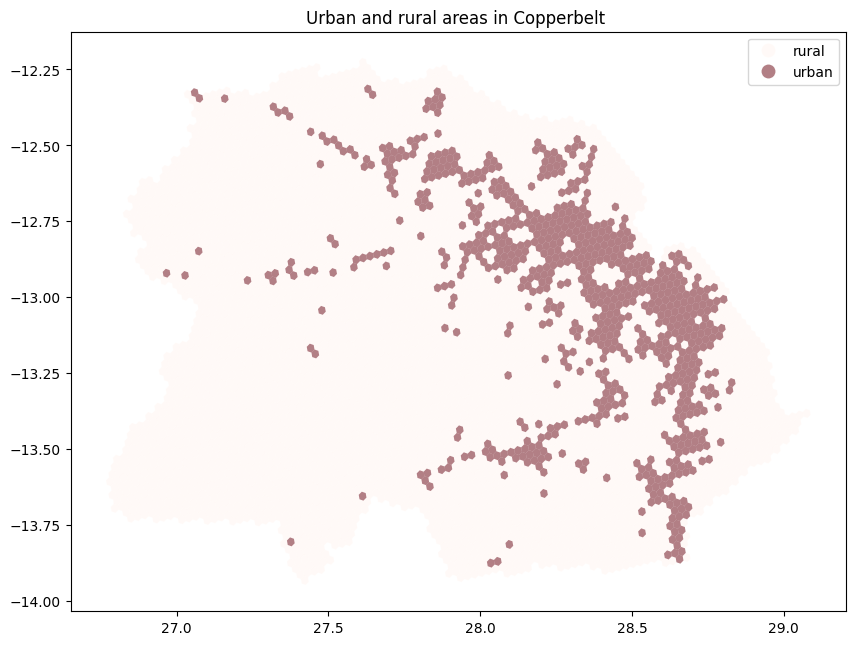

In [27]:
# map of the urban and rural areas Assessed
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
# Plot
grid.sort_values('locAssessed', ascending=True).plot(
    ax=ax, column='locAssessed', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Urban and rural areas in {} '.format("Copperbelt") )

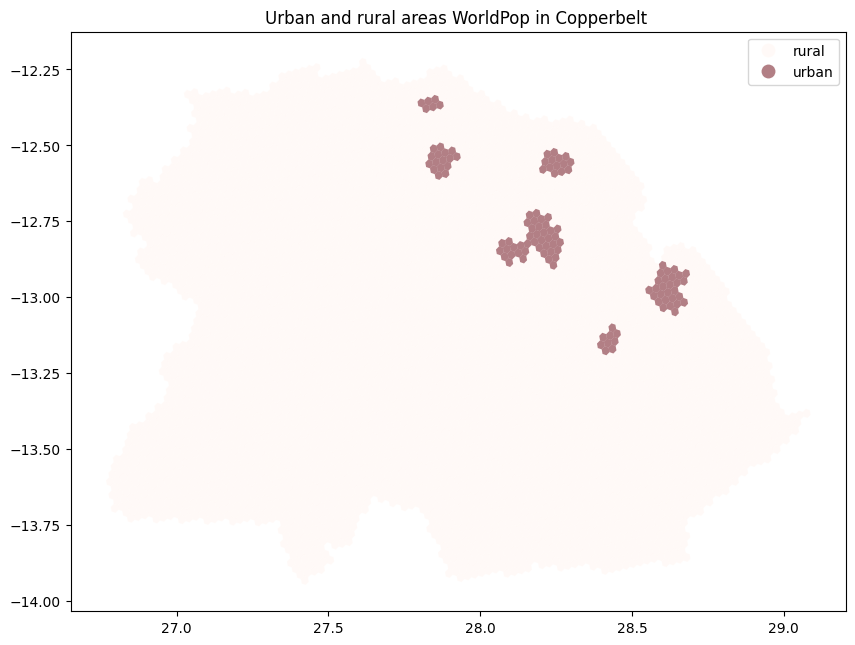

In [28]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 10))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format("Copperbelt") )

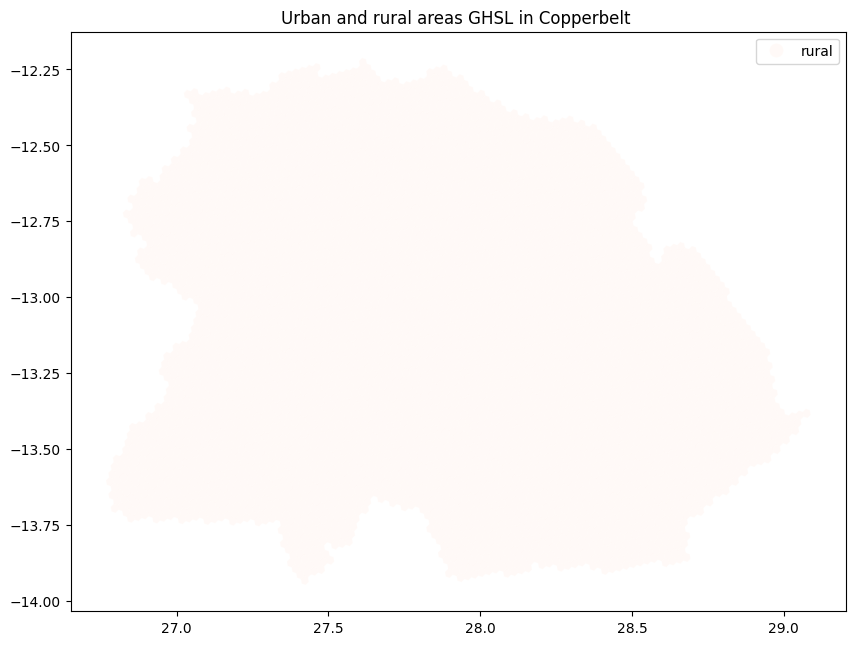

In [29]:
# map of the urban and rural areas
# Create the axis first
fig3, ax3 = plt.subplots(figsize=(10, 10))
# Plot
grid.sort_values('locGHSL', ascending=True).plot(
    ax=ax3, column='locGHSL', cmap="Reds", legend=True, alpha=0.5)

ax3.set_aspect('equal', 'box')
txt = ax3.set_title('Urban and rural areas GHSL in {} '.format("Copperbelt") )

Assess number of residential households per cell

In [ ]:
# Option 1: use buildings count from Worldpop
# total number of buildings
totalBuildings = grid["buildingscount"].sum()
urbanBuildings = np.where((grid['location'] == "urban"),grid[['buildingscount']].sum(axis=1), 0).sum()
ruralBuildings = np.where((grid['location'] == "rural"),grid[['buildingscount']].sum(axis=1), 0).sum()
print("total Buildings:",f"{totalBuildings:,.0f}")
print("urban Buildings:",f"{urbanBuildings:,.0f}")
print("rural Buildings:",f"{ruralBuildings:,.0f}")
shareRuralBuild = ruralBuildings/totalBuildings
shareUrbanBuild = urbanBuildings/totalBuildings
print("share Build urban:", f"{shareUrbanBuild:.0%}","rural:",f"{shareRuralBuild:.0%}")
resHHurban = 449077  # assessment for 2019 from the Census data 2022
resHHrural = 85356 # assessment for 2019 from the Census data 2022
# shareResBuildings = {"urban": 0.80, "rural": 0.99} # --> to change!
shareResBuildings = {"urban": 0.80, "rural": 0.5} # --> to change!
nbOfHHperResBuilding =  {"urban": 1, "rural": 1} # init
nbOfHHperResBuilding["urban"]= resHHurban/(urbanBuildings*shareResBuildings["urban"])
nbOfHHperResBuilding["rural"]= resHHrural/(ruralBuildings*shareResBuildings["rural"])
print("nb Of HH per Res Building: urban", f"{nbOfHHperResBuilding['urban']:,.1f}","rural", f"{nbOfHHperResBuilding['rural']:,.1f}")
totalResHHurban = nbOfHHperResBuilding["urban"]*urbanBuildings*shareResBuildings["urban"]
totalResHHrural = nbOfHHperResBuilding["rural"]*ruralBuildings*shareResBuildings["rural"]
totalResHH = totalResHHurban + totalResHHrural
print("total Res HH: urban", f"{totalResHHurban:,.0f}", "rural", f"{totalResHHrural:,.0f}")

In [ ]:
# Option 2 use population estimates from Worldpop
# compute total pop from world pop
totalPop=grid["popDens"].sum()
print(totalPop)
# Compare to Zamstats
totalPopStats= 2513919
pplperHH_urban = 4.7  
pplperHH_rural = 5.1
# Compute the nb off HH per cell
grid["ResHHWorldPop2_urban"]=np.where( (grid['location'] == "urban"), grid[['popDens']].sum(axis=1), 0)/pplperHH_urban
grid["ResHHWorldPop2_rural"]=np.where( (grid['location'] == "rural"), grid[['popDens']].sum(axis=1), 0)/pplperHH_rural

Assess number of residential households per cell with access to electricity

In [ ]:
# for each hexagon, assessment of the number of HH
access_elec = {"elec": 0, "nonelec": 1}
# sizeHH = {"urban": 4.7, "rural": 5.2} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#print(grid["Location"].map(shareResBuildings))
#grid["ResHHNbWithAccess"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(access_elec)

grid["ResHHNbWithAccessUrb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"),
                                                                            grid[['buildingscount']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]* grid[columnProbElec]
                                        
grid["ResHHNbWithAccessRur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"),
                                                                            grid[['buildingscount']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]* grid[columnProbElec]

grid["ResHHNbWithAccess"] = grid[["ResHHNbWithAccessUrb", "ResHHNbWithAccessRur"]].sum(axis=1)

totalResHHWithAccessUrb = grid["ResHHNbWithAccessUrb"].sum()
totalResHHWithAccessRur = grid["ResHHNbWithAccessRur"].sum()
totalResHHWithAccess = grid["ResHHNbWithAccess"].sum()
print("totalResHHWithAccessUrb:",f"{totalResHHWithAccessUrb:,.0f}")
print("totalResHHWithAccessRur:",f"{totalResHHWithAccessRur:,.0f}")
print("totalResHHWithAccess:",f"{totalResHHWithAccess:,.0f}")
# print(grid["ResHHNbWithAccessUrb"].sum() , grid["ResHHNbWithAccessRur"].sum(), grid["ResHHNbWithAccess"].sum())
grid.head(2)

In [ ]:
# access rate
accessRate = totalResHHWithAccess/totalResHH
print(accessRate)

In [ ]:
adm = grid["ADM1_NAME"].unique()
print (adm)

In [ ]:
# Energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
print(averageRwi)
grid["ResEnergyCorrPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)
# grid["ResidentialEnergy"] = grid["ResHHNbWithAccess"] * grid["ResidentialEnergyCorrPerHH"] * (grid["Status_electrified"]!="nonelec")
grid["ResEnergy"] = grid["ResHHNbWithAccess"] * grid["ResEnergyCorrPerHH"] * (grid[columnProbElec])
grid.to_csv("data.csv")
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)